<a href="https://colab.research.google.com/github/Aswin-Cheerngodan/AI-ML-books/blob/main/stock_price_model_development_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model development

Try different models like LSTM, GRU, Transformers

Importing dependencies

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, GRU, BatchNormalization, Bidirectional
from sklearn.preprocessing import StandardScaler

In [5]:
stock = "microsoft"

In [6]:
df = pd.read_csv("/content/microsoft.csv")
scaler = StandardScaler()

data = df[[ 'Open', 'Close', 'High', 'Low', 'Volume']].values

split = int(0.95*len(data))
train_data = data[:split]
test_data = data[split:]

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

train_data.shape,test_data.shape

((1471, 5), (78, 5))

In [7]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size, 0])

    return np.array(X), np.array(y)

window_size = 10
X_train, y_train = create_sequences(train_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

X_train.shape, y_train.shape

((1461, 10, 5), (1461,))

In [8]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(units=1024, return_sequences=True),
    Dropout(0.1),
    Bidirectional(LSTM(units=512, return_sequences=True)),
    Dropout(0.1),
    LSTM(units=256, return_sequences=True),
    Dropout(0.1),
    Bidirectional(LSTM(units=128, return_sequences=False)),
    Dense(units=256, activation='relu'),
    Dense(units=128, activation='tanh'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 1024)            │       4,218,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 10, 1024)            │       6,295,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 10, 256)             │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,327,425 (47.03 MB)

 Trainable params: 12,327,425 (47.03 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3,
                                                  restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'{stock}_model.keras',
                                                      save_best_only=True,
                                                      monitor='val_loss')

In [11]:
history = model.fit(X_train, y_train,
                    epochs=20, batch_size=16,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint] ,
                    verbose=1)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - loss: 0.2024 - val_loss: 0.0524
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0155 - val_loss: 0.0613
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0094 - val_loss: 0.0352
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0111 - val_loss: 0.0098
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0093 - val_loss: 0.0428
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0190 - val_loss: 0.0139
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0071 - val_loss: 0.0088
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0062 - val_loss: 0.0328
Epoch 9/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0084 - val_loss: 0.0138
Epoch 10/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 11/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 12/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.

In [12]:
model = tf.keras.models.load_model("/content/microsoft_model.keras")

In [13]:
predicted_prices = model.predict(X_train)

def inverse_transform(scaled_data, scaler):
    dummy = np.zeros((len(scaled_data), 5))
    dummy[:, 0] = scaled_data.flatten()
    return scaler.inverse_transform(dummy)[:, 0]

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [14]:
actual_prices = inverse_transform(y_train, scaler)
predicted_prices = inverse_transform(predicted_prices, scaler)

actual_prices.shape, predicted_prices.shape

((1461,), (1461,))

In [15]:
test_data.shape

(78, 5)

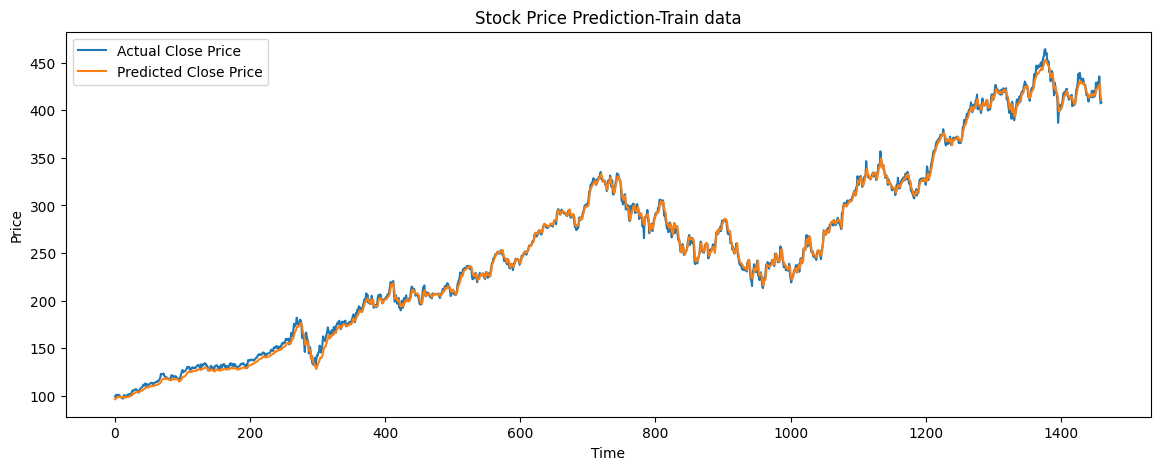

In [16]:
plt.figure(figsize=(14,5))
plt.plot(actual_prices, label='Actual Close Price')
plt.plot(predicted_prices, label='Predicted Close Price')
plt.title('Stock Price Prediction-Train data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


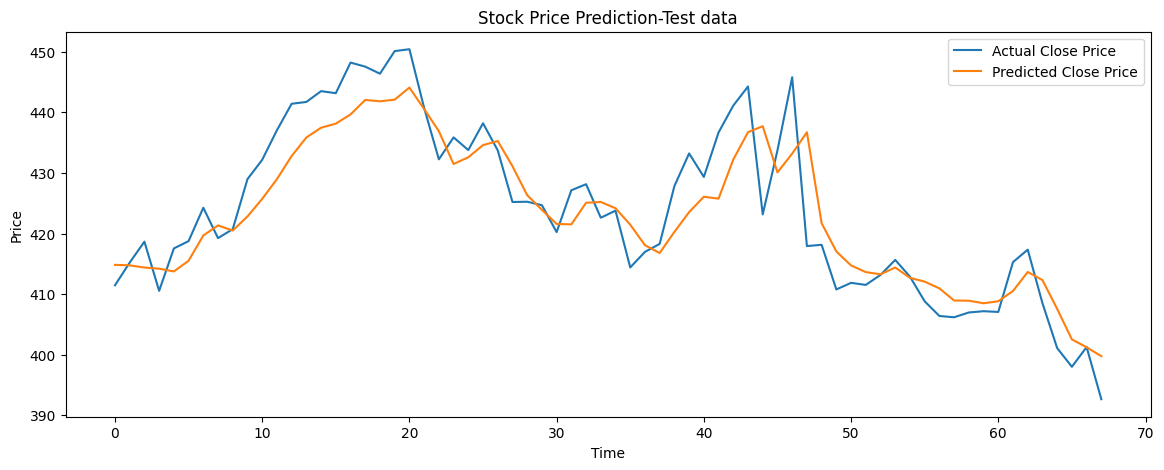

In [17]:
predicted_prices = model.predict(X_test)

actual_prices = inverse_transform(y_test, scaler)
predicted_prices = inverse_transform(predicted_prices, scaler)

plt.figure(figsize=(14,5))
plt.plot(actual_prices, label='Actual Close Price')
plt.plot(predicted_prices, label='Predicted Close Price')
plt.title('Stock Price Prediction-Test data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_absolute_percentage_error

mse = mean_absolute_percentage_error(actual_prices, predicted_prices)
print(mse)

0.01069590838184628


In [19]:
import joblib

joblib.dump(scaler, f"{stock}_scaler.pkl")

['microsoft_scaler.pkl']